# Deploy a trained Keras MobileNet V2 model with Tensorflow Servning

I am going to walk you through a complete a guideline of how to:

**Part 1:**
- Prepare data for training 
- Trained a deep learning model

**Part 2:**
- Serve the model with Tensorflow serving.
- Deploy to [Heroku](https://www.heroku.com/).

**In order to fully benefits from this services:**
- You should be familiar with python.
- You should have some understanding of what deep learning and neural network is.


# Helper functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def show_images(images):
    """
    images : numpy arrays
    """
    n_images = len(images)
    titles = ['(%d)' % i for i in range(1, n_images + 1)]
    num = 5
    iter_num = np.ceil(n_images / num).astype(int)
    for i in range(iter_num):
        fig = plt.figure()
        sub_images = images[i * num:num * (i + 1)]
        sub_titles = titles[i * num:num * (i + 1)]
        for n, (image, title) in enumerate(zip(sub_images, sub_titles)):
            a = fig.add_subplot(1, np.ceil(len(sub_images)), n + 1)
            if image.ndim == 2:
                plt.gray()
            a.set_title(title, fontsize=15)
            plt.imshow(image)


## Prepare data for training

For the sake of simplicity, I am going to use the fashion mnist dataset because it is already optimized and labeled for a classification problem. 
Read more about the Fashion-MINST dataset in this paper [here](https://arxiv.org/abs/1708.07747)
To download dataset and check other examples [here](https://github.com/zalandoresearch/fashion-mnist)

It has 70,000 images, and each image is a grayscale of the size (28X28). 
which are categories into the following:

|Lable|Description|  
|-  |      -      |
| 0 | T-shirt/top | 
| 1 | Trouser     | 
| 2 | Pullover    |  
| 3 | Dress       | 
| 4 | Coat        | 
| 5 | Sandal      | 
| 6 | Shirt       |
| 7 | Sneaker     | 
| 8 | Bag         | 
| 9 | Ankle boot  | 


Let's start downloading the dataset. 
fortunately, many deep learning (DL) frameworks support fashion mnist dataset out of the box, 
including keras in our case.

In [2]:
import keras

# Load the fashion-mnist train data and test data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

/Users/MoAir/anaconda/envs/g/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x_train shape: (60000, 28, 28) y_train shape: (60000,)


By default `keras.datasets.fashion_mnist.load_data()` is returning training and testing dataset. 
It is essential to split the dataset into training and  testing. 
Train data: This data actually to train the neural network (NN) 
Test: To valid the NN during the traning phase, by tuning and re-adjust the hyperparameters. 
hyperparameter is a parameter whose value is set before the learning process begins.(we will see them later)

**However sometime we see train, valid and test dataset, why?**

Glad you ask!

After training the NN, we run the training NN against a our validation dataset 
to make sure that the model is generalized and is not overfitting. Overfitting basically means a model only predict the right result with the training data. However, if a model predicts the incorrectly result for the training data it's called underfitting. Here is a nice explination of [overfitting and underfitting](https://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76).


If the validation result was not pleased, we retrain the NN with different hyperparameters and we repeat this until we reach to a satisfied result. Now if the tranined and validation dataset have the result or score we want, we would think we are done. Not so fast!. Since we adjust the hyperparameters, we could lead the model to overfit in both train and valid dataset. To avoid this, we split the dataset into Train, Valid, and Test. 
After getting the desired score in both train and valid data, we run the model against the test dataset. Usually the test dataset should be closed to the validation result. For example getting 90% in valid data, and 87% in testing is acceptable.

### Resize images

Because we are going to use [MobileNet V2](https://keras.io/applications/#mobilenetv2) model which accept (96 , 96 ,3) format as minimum image size.

We need to rescale the image from (28 X 28) to (96 X 96 X 3). 

Here are the supported formats;
> If imagenet weights are being loaded, input must have a static square shape(one of (96, 96), (128, 128), (160, 160),(192, 192), or (224, 224)).

### Show images before resizing

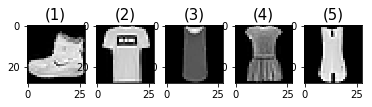

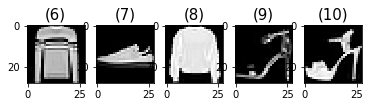

In [3]:
show_images(x_train[:10])

#### Resize images

In [13]:
from PIL import Image
target_size = 96
def rescale_images(x):
    rgb_channel_image = np.stack((x,)*3, axis=-1).astype(np.uint8)
    resize_image = np.array(Image.fromarray(x).resize((target_size,target_size)))
    return resize_image.astype(np.float32)

rescale_x_train = np.array(list(map(rescale_images,x_train[:30000])))
rescale_x_test = np.array(list(map(rescale_images,x_test)))


(30000, 96, 96)


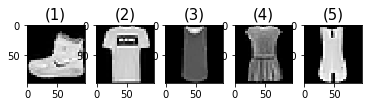

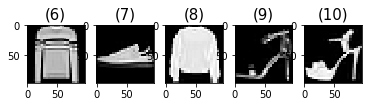

In [14]:
print(rescale_x_train.shape)
show_images(rescale_x_train[:10])

### Convert labels (y_train and y_test) to one hot encoding
A one hot encoding is a representation of categorical variables as binary vectors.

[Here is the full explanation](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)

In [15]:
y_train = keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')


### Data normalization
Normalize the data dimensions so that they are of approximately the same scale.In general, normalization makes very deep NN easier to train, special in Convolutional and Recurrent neural network.

Here is a nice explanation [video](https://www.coursera.org/lecture/deep-neural-network/normalizing-activations-in-a-network-4ptp2) and an [article](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17)

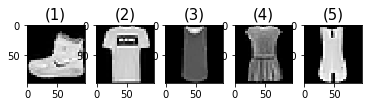

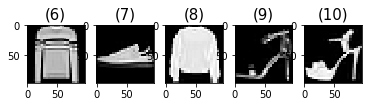

In [18]:
norm_x_train = rescale_x_train.astype('float32') / 255
norm_x_test = rescale_x_test.astype('float32') / 255
# dsiplay images
show_images(norm_x_train[:10])

## Train a deep learning Model

I have chosn MobileNet V2 model becuase its faster to train and it is small in size. [Documentation for Individual Models](https://keras.io/applications/#documentation-for-individual-models) 

In [19]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.layers import Dense, Input, Dropout
from keras.models import Model

def build_model( ):
    input_tensor = Input(shape=(target_size, target_size, 3))
    app_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=(target_size, target_size, 3),
        pooling='avg')

    for layer in app_model.layers:
        layer.trainable = False  # trainable has to be false in order to freez the layers
        
    op = Dense(256, activation='relu')(app_model.output)
    op = Dropout(.25)(op)
    outputs = Dense(10, activation='softmax')(op)

    model = Model(inputs=input_tensor, outputs=outputs)


    return model


In [ ]:
model = build_model()
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
model.fit(x=rescale_x_train[:1000],
            y=y_train[:1000],
            batch_size=128,
            epochs=1,
            verbose=1,
            shuffle=True)

In [ ]:
model.evaluate(x=rescale_x_test[:100],
               y=y_test[:100], 
               batch_size=32, 
               verbose=1)
